# Acquiring data set

In [1]:
!wget https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
!unzip gzip.zip 
!rm gzip.zip
!pip install python-mnist

--2022-07-27 21:20:25--  https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
Resolving www.itl.nist.gov (www.itl.nist.gov)... 129.6.13.19, 2610:20:6b01:4::175
Connecting to www.itl.nist.gov (www.itl.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561753746 (536M) [application/zip]
Saving to: ‘gzip.zip’

gzip.zip            100%[===================>] 535.73M   819KB/s    in 8m 28s  

2022-07-27 21:28:55 (1.05 MB/s) - ‘gzip.zip’ saved [561753746/561753746]

Archive:  gzip.zip
  inflating: gzip/emnist-balanced-mapping.txt  
  inflating: gzip/emnist-balanced-test-images-idx3-ubyte.gz  
 extracting: gzip/emnist-balanced-test-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-balanced-train-images-idx3-ubyte.gz  
  inflating: gzip/emnist-balanced-train-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-byclass-mapping.txt  
  inflating: gzip/emnist-byclass-test-images-idx3-ubyte.gz  
  inflating: gzip/emnist-byclass-test-labels-idx1-ubyte.gz  

# Import modules

In [2]:
import os
import numpy as np
import tensorflow as tf
from mnist import MNIST
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense

In [3]:
try:
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu_resolver = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
    tf.config.experimental_connect_to_cluster(tpu_resolver)
    tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
    strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
    print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


2022-07-27 21:29:01.265490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 21:29:01.282962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 21:29:01.283319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 21:29:01.284501: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Preparing data set

In [4]:
# load the entire EMNIST dataset as numpy arrays (this might take a while)
emnist_data = MNIST(path='gzip', return_type='numpy')
emnist_data.select_emnist('byclass')
x_train, y_train = emnist_data.load_training()
x_test, y_test = emnist_data.load_testing()

In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((697932, 784), (697932,), (116323, 784), (116323,))

In [6]:
img_side = 28

# Reshape tensors to [n, y, x, 1] and normalize the pixel values between [0, 1]
x_train = x_train.reshape(-1, img_side, img_side, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, img_side, img_side, 1).astype('float32') / 255.0

x_train.shape, x_test.shape

((697932, 28, 28, 1), (116323, 28, 28, 1))

In [7]:
# get number of classes
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)

input_shape = (img_side, img_side, 1)

# weight the classes (to combat the imbalance)
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = unique_classes,
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))

# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
kernel_size = (5, 5)
def createmodel():
    return Sequential([
        Convolution2D(16, kernel_size=kernel_size, padding='same', input_shape=input_shape, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.4),
        Convolution2D(32, kernel_size=kernel_size, padding='same', activation= 'relu'), #strides=2,
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.4),
        Convolution2D(64, kernel_size=kernel_size, padding='same', activation= 'relu'),
        MaxPooling2D(pool_size =(2,2)),
        BatchNormalization(),
        Dropout(0.4),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax'),
    ])

In [13]:
# setting up model to run on cpu, or gpu when avaiable
with strategy.scope():
    model = createmodel()
    model.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [14]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        12832     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)        

# Train model

In [15]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True)

In [16]:
history = model.fit(x_train, y_train,
          #class_weight=class_weights,
          batch_size=10000,
          epochs=200,
          verbose=1,
          shuffle=True,
          validation_data=(x_test, y_test),
          callbacks=[es])

2022-07-27 21:31:28.620836: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2188714752 exceeds 10% of free system memory.
2022-07-27 21:31:29.551123: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2188714752 exceeds 10% of free system memory.


Epoch 1/200


2022-07-27 21:31:30.959049: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-07-27 21:31:30.959074: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-07-27 21:31:31.015723: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-07-27 21:31:31.015749: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

70/70 [==============================] - 8s 93ms/step - loss: 1.7234 - accuracy: 0.5603 - val_loss: 4.7153 - val_accuracy: 0.0188
Epoch 2/200
70/70 [==============================] - 5s 71ms/step - loss: 0.7838 - accuracy: 0.7514 - val_loss: 5.3614 - val_accuracy: 0.0178
Epoch 3/200
70/70 [==============================] - 5s 70ms/step - loss: 0.6502 - accuracy: 0.7865 - val_loss: 4.6149 - val_accuracy: 0.0314
Epoch 4/200
70/70 [==============================] - 5s 71ms/step - loss: 0.5879 - accuracy: 0.8036 - val_loss: 3.1413 - val_accuracy: 0.1772
Epoch 5/200
70/70 [==============================] - 5s 71ms/step - loss: 0.5504 - accuracy: 0.8141 - val_loss: 1.8786 - val_accuracy: 0.4553
Epoch 6/200
70/70 [==============================] - 5s 71ms/step - loss: 0.5253 - accuracy: 0.8210 - val_loss: 0.9719 - val_accuracy: 0.7038
Epoch 7/200
70/70 [==============================] - 5s 72ms/step - loss: 0.5067 - accuracy: 0.8259 - val_loss: 0.6714 - val_accuracy: 0.7719
Epoch 8/200
70/70 

# Evaluate model

In [17]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3636/3636 [==============================] - 5s 1ms/step - loss: 0.3364 - accuracy: 0.8728
Test loss: 0.33641672134399414
Test accuracy: 0.8727680444717407


In [ ]:
import matplotlib.pyplot as plt
def plotres(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title(metric.upper())
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

plotres(history.history, "accuracy")
plotres(history.history, "loss")

In [25]:
y_pred = model.predict(x_test)

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

<AxesSubplot:>

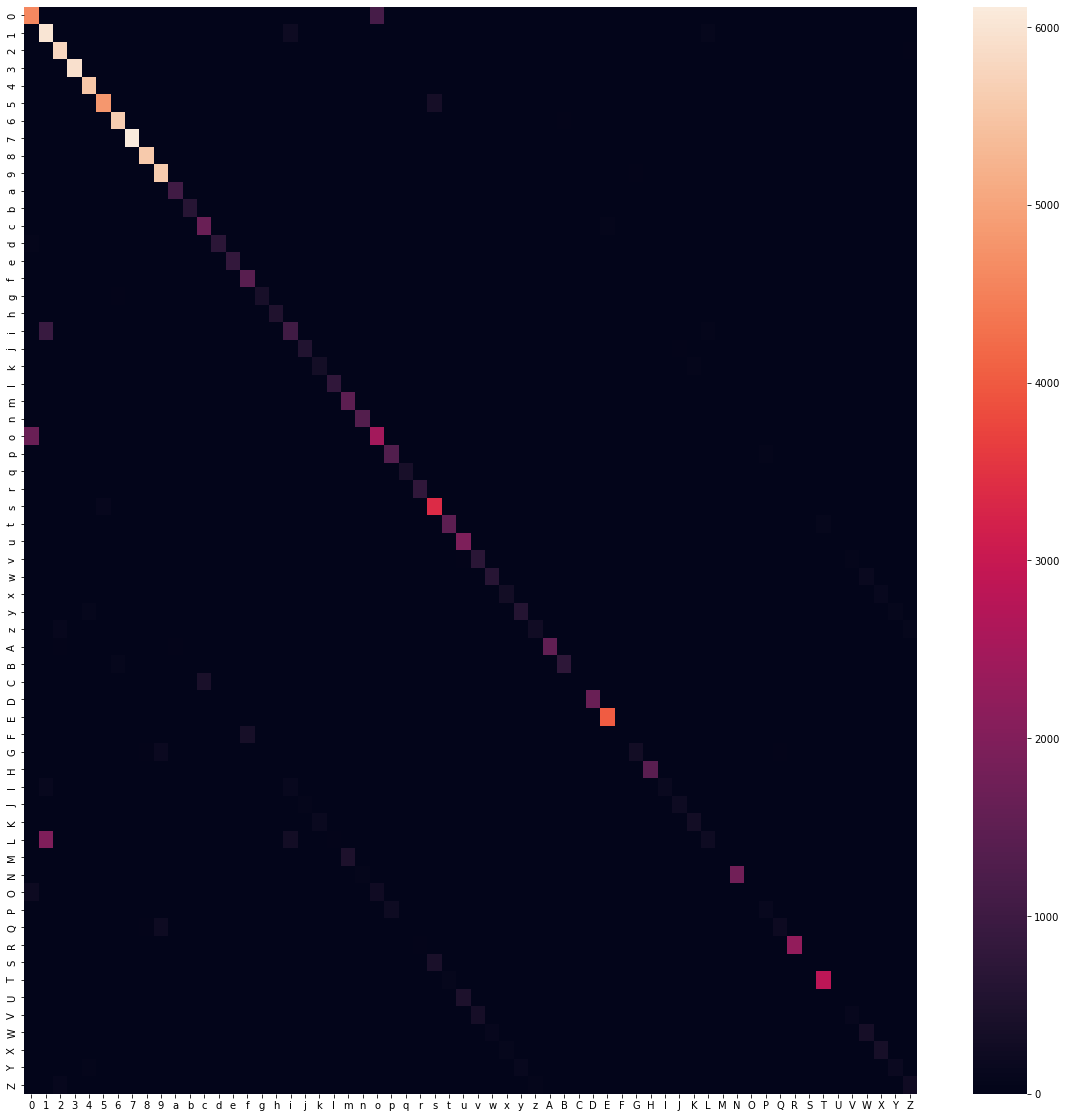

In [27]:
labels = string.digits+string.ascii_lowercase+string.ascii_uppercase
plt.subplots(figsize=(20,20))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)), xticklabels=labels, yticklabels=labels)

# Convert model to JavaScript

In [28]:
model.save("model/cnn_emnist.h5")

In [29]:
!pip install tensorflowjs

     |████████████████████████████████| 78 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 108 kB 9.3 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 4.0 MB/s  eta 0:00:01


  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.4
    Uninstalling protobuf-3.19.4:
      Successfully uninstalled protobuf-3.19.4
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3


In [30]:
!tensorflowjs_converter --input_format keras "model/cnn_emnist.h5" ./model
!zip -r jsmodel.zip model/

  adding: jsmodel/ (stored 0%)
  adding: jsmodel/model.json (deflated 87%)
  adding: jsmodel/group1-shard1of1.bin (deflated 7%)
